# Start of The Proj

In [134]:
import pandas as pd
import pm4py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from scipy.stats import chi2_contingency

### Loading the Dataset

In [135]:
log = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/BIS2022/main/Event%20Logs/Road_Traffic_Fine_Management_Process.csv',sep=',')
log.rename(columns={'Case ID': 'case:concept:name', 'Complete Timestamp': 'time:timestamp', 'Activity': 'concept:name', 'Resource': 'org:resource'}, inplace=True)

In [136]:
log['time:timestamp']= pd.to_datetime(log['time:timestamp'])

num_events = len(log)
num_cases = len(log['case:concept:name'].unique())
print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))

start_activities = pm4py.get_start_activities(log)
end_activities = pm4py.get_end_activities(log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Number of events: 561470
Number of cases: 150370
Start activities: {'Create Fine': 150370}
End activities: {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}


In [137]:
log

,case:concept:name,concept:name,org:resource,time:timestamp,Variant,Variant index,amount,dismissal,vehicleClass,totalPaymentAmount,lifecycle:transition,article,points,expense,notificationType,lastSent,paymentAmount,matricola
0,A1,Create Fine,561.0,2006-07-24,Variant 3,3,35.0,NIL,A,0.0,complete,157.0,0.0,NaN,NaN,NaN,NaN,NaN
1,A1,Send Fine,NaN,2006-12-05,Variant 3,3,NaN,NaN,NaN,NaN,complete,NaN,NaN,11.00,NaN,NaN,NaN,NaN
2,A100,Create Fine,561.0,2006-08-02,Variant 1,1,35.0,NIL,A,0.0,complete,157.0,0.0,NaN,NaN,NaN,NaN,NaN
3,A100,Send Fine,NaN,2006-12-12,Variant 1,1,NaN,NaN,NaN,NaN,complete,NaN,NaN,11.00,NaN,NaN,NaN,NaN
4,A100,Insert Fine Notification,NaN,2007-01-15,Variant 1,1,NaN,NaN,NaN,NaN,complete,NaN,NaN,NaN,P,P,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,V9999,Create Fine,25.0,2002-09-07,Variant 1,1,131.0,NIL,A,0.0,complete,142.0,0.0,NaN,NaN,NaN,NaN,NaN
561466,V9999,Send Fine,NaN,2002-10-25,Variant 1,1,NaN,NaN,NaN,NaN,complete,NaN,NaN,15.16,NaN,NaN,NaN,NaN
561467,V9999,Insert Fine Notification,NaN,2002-11-04,Variant 1,1,NaN,NaN,NaN,NaN,complete,NaN,NaN,NaN,P,N,NaN,NaN
561468,V9999,Add penalty,NaN,2003-01-03,Variant 1,1,262.0,NaN,NaN,NaN,complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
case_durations = log.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
# Multiple aggregations of the same column using pandas ...
FirstOccurence=('time:timestamp', lambda x: x.min()),
LastOccurence=('time:timestamp', lambda x: x.max()),
Duration=('time:timestamp', lambda x: x.max() - x.min()),
)

In [139]:
case_durations

,Events,FirstOccurence,LastOccurence,Duration
case:concept:name,,,,
A1,2,2006-07-24,2006-12-05,134 days
A100,5,2006-08-02,2009-03-30,971 days
A10000,5,2007-03-09,2008-09-09,550 days
A10001,6,2007-03-19,2007-09-24,189 days
A10004,5,2007-03-20,2009-03-30,741 days
...,...,...,...,...
V9995,5,2002-09-07,2004-01-10,490 days
V9996,3,2002-09-07,2002-11-06,60 days
V9997,5,2002-09-07,2004-01-10,490 days


In [140]:
min_case_duration = case_durations['Duration'].min()
max_case_duration = case_durations['Duration'].max()
mean_case_duration = case_durations['Duration'].mean()

print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration, max_case_duration, mean_case_duration))

filtered_log = pm4py.filter_case_performance(log, 0, 0)


print("Given {} total cases in the log we have {} cases that comply with the applied filter".format(len(log['case:concept:name'].unique()), len(filtered_log['case:concept:name'].unique())))


Min Case Duration: 0 days 00:00:00
Max Case Duration: 4372 days 00:00:00
Mean Case Duration: 341 days 16:06:01.029460664
Given 150370 total cases in the log we have 4920 cases that comply with the applied filter


## # Visualization

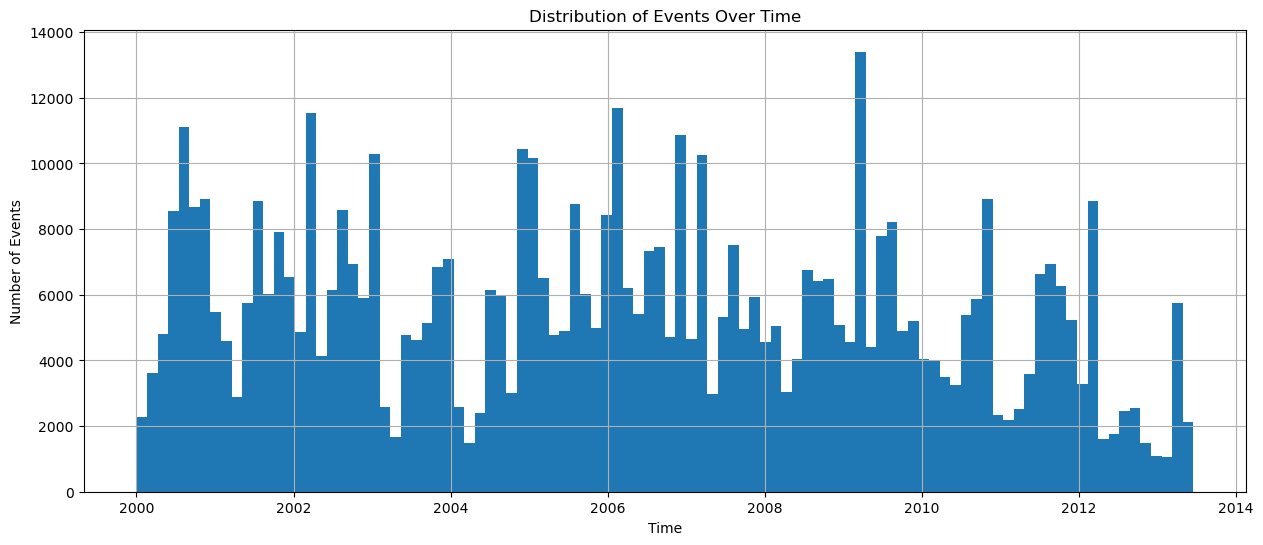

In [141]:
# Distribution of events over time
plt.figure(figsize=(15, 6))
log['time:timestamp'].hist(bins=100)
plt.title('Distribution of Events Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.show()


In [142]:
# Check for other start activities
if len(start_activities) == 1:
    print("All cases start with the same activity: 'Create Fine'.")
else:
    start_activities_count = pd.DataFrame(list(start_activities.items()), columns=['Activity', 'Count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Activity', y='Count', data=start_activities_count)
    plt.title('Start Activities Count')
    plt.xlabel('Activity')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

All cases start with the same activity: 'Create Fine'.


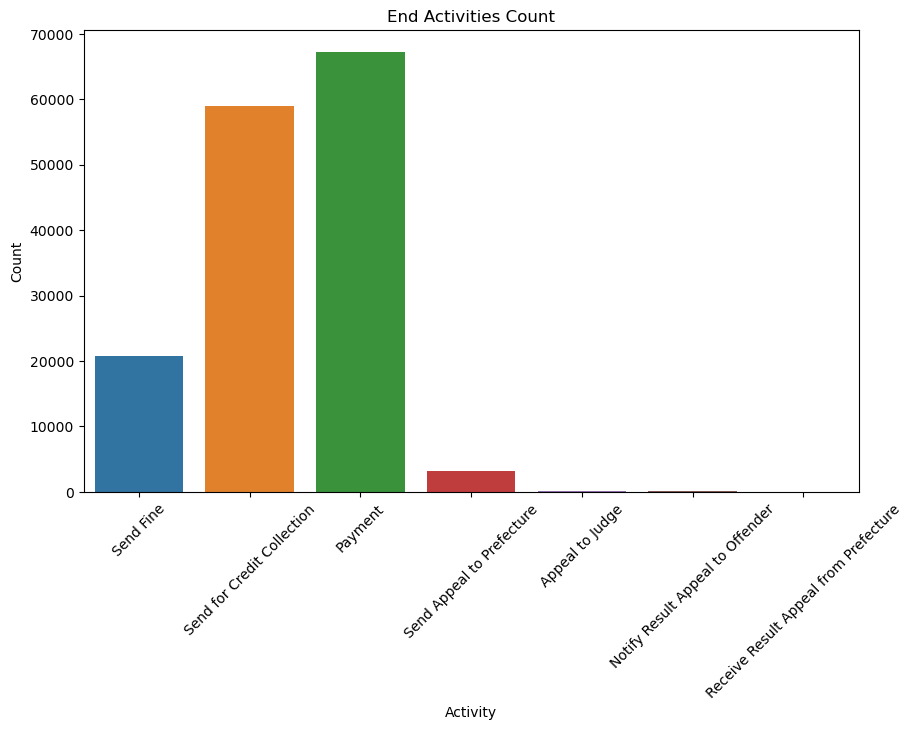

In [143]:
# End activities plot
end_activities_count = pd.DataFrame(list(end_activities.items()), columns=['Activity', 'Count'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Activity', y='Count', data=end_activities_count)
plt.title('End Activities Count')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

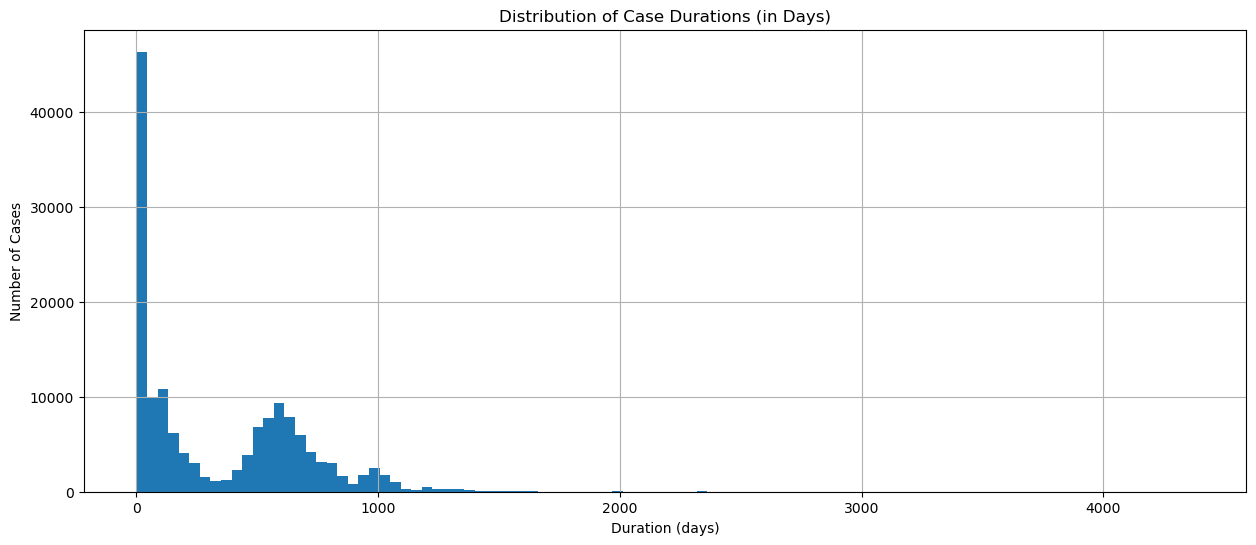

In [144]:
# Case duration distribution
plt.figure(figsize=(15, 6))
case_durations['Duration'].dt.days.hist(bins=100)
plt.title('Distribution of Case Durations (in Days)')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Cases')
plt.show()

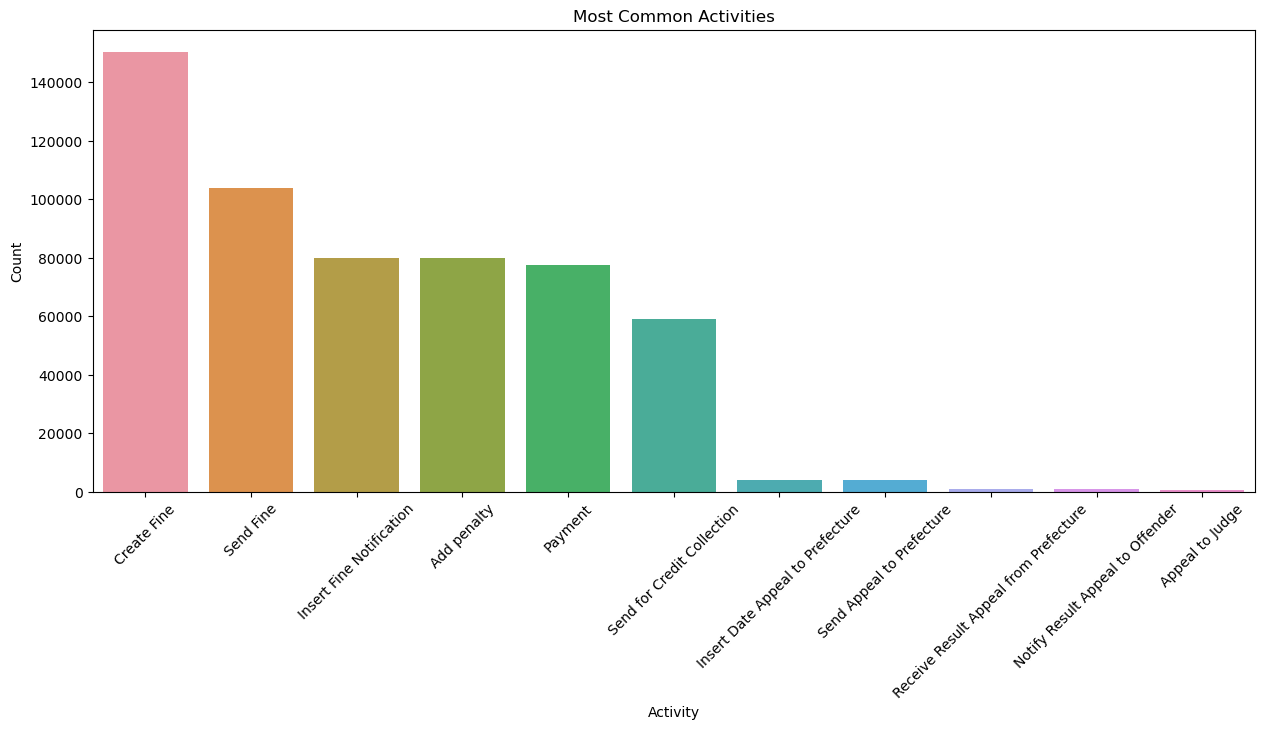

In [145]:
# Most common activities
activity_counts = log['concept:name'].value_counts()
plt.figure(figsize=(15, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values)
plt.title('Most Common Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

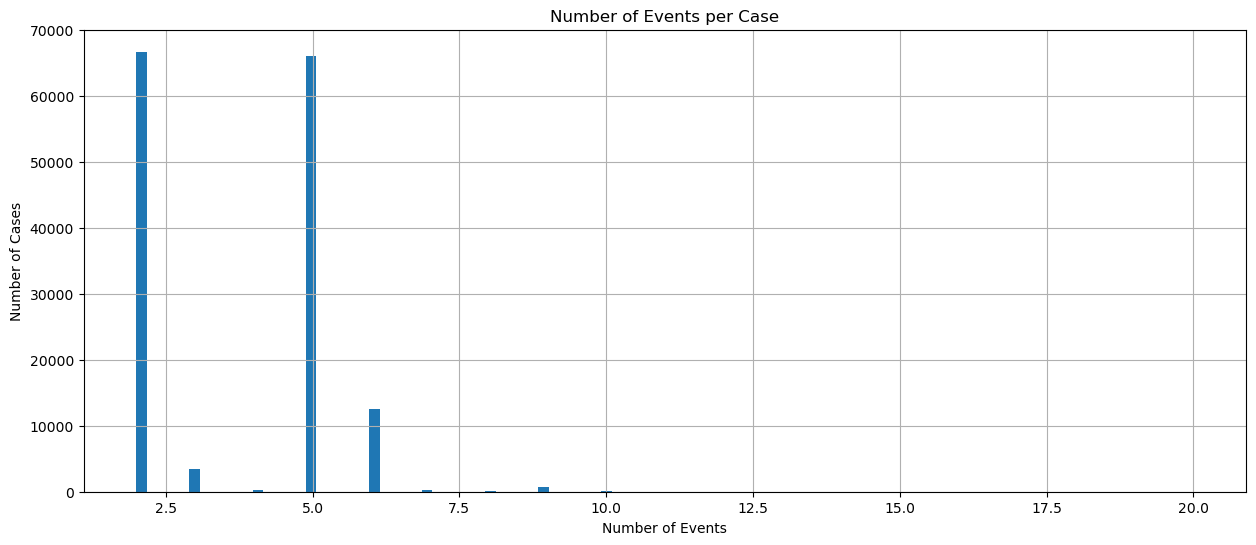

In [146]:
# Event count per case
event_counts_per_case = log.groupby('case:concept:name').size()
plt.figure(figsize=(15, 6))
event_counts_per_case.hist(bins=100)
plt.title('Number of Events per Case')
plt.xlabel('Number of Events')
plt.ylabel('Number of Cases')
plt.show()

### Filtering the "Create Fine", "Send Fine" events, with duration 0


In [147]:
# Step 1: Filter cases with duration zero and not ending with a payment activity
initial_cases = len(log['case:concept:name'].unique())
filtered_log = pm4py.filter_variants(log, [('Create Fine', 'Send Fine')], retain=True)
filtered_log = pm4py.filter_case_performance(filtered_log, 0, 0)
log = pd.concat([log, filtered_log]).drop_duplicates(keep=False)
remaining_cases = len(log['case:concept:name'].unique())
print(f"Step 1: Removed {initial_cases - remaining_cases} cases with duration zero not ending in payment activity.")


Step 1: Removed 118 cases with duration zero not ending in payment activity.


### Incomplete cases

In [148]:
## Let's consider incomplete all cases not ending with a legal end activity like Payment or Send for Credit Collection

initial_cases = remaining_cases
filtered_log = pm4py.filter_end_activities(log, ['Payment', 'Send for Credit Collection', 'Send Appeal to Prefecture', 'Appeal to Judge'])
remaining_cases = len(filtered_log['case:concept:name'].unique())
print(f"Step 2: Remaining cases after filtering incomplete cases: {remaining_cases}")

Step 2: Remaining cases after filtering incomplete cases: 129476


### Further filter 'Send Appeal to Prefecture' and 'Appeal to Judge' cases based on 'dismissal' attribute

In [149]:
filtered_log_att = pm4py.filter_end_activities(log, ['Send Appeal to Prefecture', 'Appeal to Judge'])
filtered_log_att = pm4py.filter_trace_attribute_values(filtered_log_att, 'dismissal', ['#', 'G'])
filtered_log = pd.concat([filtered_log, filtered_log_att]).drop_duplicates(keep=False)
remaining_cases = len(filtered_log['case:concept:name'].unique())
print(f"Step 3: Remaining cases after filtering based on 'dismissal' attribute: {remaining_cases}")


Step 3: Remaining cases after filtering based on 'dismissal' attribute: 127437


### Remove cases where penalty was added despite timely payment

In [150]:
grouped = filtered_log.groupby('case:concept:name')
wrongly_added_penalties = []

for case_id, group in grouped:
    if 'Add penalty' not in group['concept:name'].values or 'Payment' not in group['concept:name'].values:
        continue

    create_fine = group[group['concept:name'] == 'Create Fine'].iloc[0]
    amount = create_fine['amount']
    create_fine_time = create_fine['time:timestamp']
    payments_within_180_days = group[(group['concept:name'] == 'Payment') & (group['time:timestamp'] <= create_fine_time + pd.Timedelta(days=180))]

    if not payments_within_180_days.empty:
        total_payment_amount = payments_within_180_days['totalPaymentAmount'].max()
        if isinstance(total_payment_amount, str):
            total_payment_amount = float(total_payment_amount)

        if total_payment_amount >= amount:
            wrongly_added_penalties.append(case_id)


In [151]:
# Filter out the cases in the blacklist
previous_length = len(filtered_log['case:concept:name'].unique())
filtered_log = filtered_log[~filtered_log['case:concept:name'].isin(wrongly_added_penalties)]
print(f"Step 4: Removed {previous_length - len(filtered_log['case:concept:name'].unique())} cases with wrongly added penalties.")


Step 4: Removed 7223 cases with wrongly added penalties.


In [153]:
# Remove redundant activities (example: if 'Send Fine' is followed immediately by 'Create Fine')
def remove_redundant_activities(filtered_log):
    redundant_cases = []
    for case_id, group in filtered_log.groupby('case:concept:name'):
        activities = group['concept:name'].values
        if any(activities[i] == 'Send Fine' and activities[i+1] == 'Create Fine' for i in range(len(activities) - 1)):
            redundant_cases.append(case_id)
    return filtered_log[~filtered_log['case:concept:name'].isin(redundant_cases)]

filtered_log = remove_redundant_activities(filtered_log)
print(f"Number of cases after removing redundant activities: {len(filtered_log['case:concept:name'].unique())}")


Number of cases after removing redundant activities: 120214


In [154]:
def remove_low_frequency_variants(filtered_log, min_frequency):
    # Get the variants and their frequencies
    variants = pm4py.get_variants(filtered_log)
    
    # Filter out variants that occur less than the minimum frequency
    frequent_variants = {variant: freq for variant, freq in variants.items() if freq >= min_frequency}
    
    # Get the trace variants of frequent variants
    frequent_trace_variants = list(frequent_variants.keys())
    
    # Filter the log to retain only frequent cases
    filtered_log = pm4py.filter_variants(filtered_log, frequent_trace_variants)
    
    return filtered_log


filtered_log = remove_low_frequency_variants(filtered_log, 5)   # 5 is the minimum frequency
print(f"Number of cases after removing low frequency variants: {len(filtered_log['case:concept:name'].unique())}")

Number of cases after removing low frequency variants: 120009


In [155]:
# Ensure there are no duplicate events within a case
filtered_log = filtered_log.drop_duplicates(subset=['case:concept:name', 'time:timestamp', 'concept:name'])
print(f"Number of cases after removing duplicates: {len(filtered_log['case:concept:name'].unique())}")


Number of cases after removing duplicates: 120009


In [156]:
# Final statistics
num_events = len(filtered_log)
num_cases = len(filtered_log['case:concept:name'].unique())
print("Final number of events: {}\nFinal number of cases: {}".format(num_events, num_cases))


Final number of events: 462891
Final number of cases: 120009


In [157]:
# Distribution of case durations
case_durations = filtered_log.groupby('case:concept:name').agg(
    Events=('case:concept:name', 'count'),
    FirstOccurence=('time:timestamp', lambda x: x.min()),
    LastOccurence=('time:timestamp', lambda x: x.max()),
    Duration=('time:timestamp', lambda x: x.max() - x.min())
)

min_case_duration = case_durations['Duration'].min()
max_case_duration = case_durations['Duration'].max()
mean_case_duration = case_durations['Duration'].mean()

print("Filtered event log:\nMin Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_case_duration, max_case_duration, mean_case_duration))


Filtered event log:
Min Case Duration: 0 days 00:00:00
Max Case Duration: 4372 days 00:00:00
Mean Case Duration: 390 days 08:00:26.638002148


In [158]:
# Variants analysis
log = log.astype({'case:concept:name': str, 'concept:name': str, 'time:timestamp': 'datetime64[ns]'})

# Convert the pandas DataFrame to an event log format that pm4py expects
event_log = pm4py.convert_to_event_log(filtered_log)

# Get variants
variants = pm4py.get_variants(event_log)

# Sort variants by the number of cases they have
sorted_variants = sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)

print("Variants count: ", len(sorted_variants), "\n\n", "The 7 most common variants:\n")
for variant, cases in sorted_variants[:7]:
    print(f"Variant: {variant}, Cases: {len(cases)}")

Variants count:  54 

 The 7 most common variants:

Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection'), Cases: 56482
Variant: ('Create Fine', 'Payment'), Cases: 46372
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment'), Cases: 7652
Variant: ('Create Fine', 'Send Fine', 'Payment'), Cases: 3134
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment'), Cases: 2326
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Send for Credit Collection'), Cases: 1012
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture'), Cases: 876


### .........................................................................
### Specific recommendations for early detection of dysfunctional executions:

In [159]:
# Add this after your anomaly detection steps

# Identify potential indicators of dysfunctional executions
filtered_log['time_since_previous'] = filtered_log.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds() / 86400

# Long delays between activities
long_delay_threshold = filtered_log['time_since_previous'].quantile(0.95)  # 95th percentile
long_delay_cases = filtered_log[filtered_log['time_since_previous'] > long_delay_threshold]['case:concept:name'].unique()

# Unusual activity sequences
unusual_sequences = filtered_log.groupby('case:concept:name').apply(lambda x: '->'.join(x['concept:name']))
rare_sequences = unusual_sequences.value_counts()[unusual_sequences.value_counts() < 5].index

print("Recommendations for early detection of dysfunctional executions:")
print(f"1. Monitor cases with delays longer than {long_delay_threshold:.2f} days between activities.")
print(f"2. Pay attention to cases with unusual activity sequences. Some examples:")
for seq in rare_sequences[:5]:  # Show top 5 rare sequences
    print(f"   - {seq}")
print("3. Implement automatic alerts for cases that exceed the 95th percentile of processing time.")

Recommendations for early detection of dysfunctional executions:
1. Monitor cases with delays longer than 591.00 days between activities.
2. Pay attention to cases with unusual activity sequences. Some examples:
3. Implement automatic alerts for cases that exceed the 95th percentile of processing time.


### Summarizing

In [160]:
# Summarizing

## Let's get the variants of the filtered log

variants = pm4py.get_variants(filtered_log)
#print(variants)
variants_df = pd.DataFrame.from_dict(variants, orient='index', columns=['Count'])
# create a new column with index values
#variants_df['Variant'] = variants_df.index
variants_df = variants_df.reset_index()
variants_df = variants_df.rename(columns={'index': 'Variant'})
variants_df = variants_df.sort_values(by=['Count'], ascending=False)
variants_df = variants_df.reset_index(drop=True)
variants_df


,Variant,Count
0,"(Create Fine, Send Fine, Insert Fine Notificat...",56482
1,"(Create Fine, Payment)",46372
2,"(Create Fine, Send Fine, Insert Fine Notificat...",7652
3,"(Create Fine, Send Fine, Payment)",3134
4,"(Create Fine, Send Fine, Insert Fine Notificat...",2326
5,"(Create Fine, Send Fine, Insert Fine Notificat...",1012
6,"(Create Fine, Send Fine, Insert Fine Notificat...",876
7,"(Create Fine, Send Fine, Insert Fine Notificat...",598
8,"(Create Fine, Send Fine, Insert Fine Notificat...",190
9,"(Create Fine, Send Fine, Insert Fine Notificat...",136


### Event Variants Analysis Using CDF and PDF

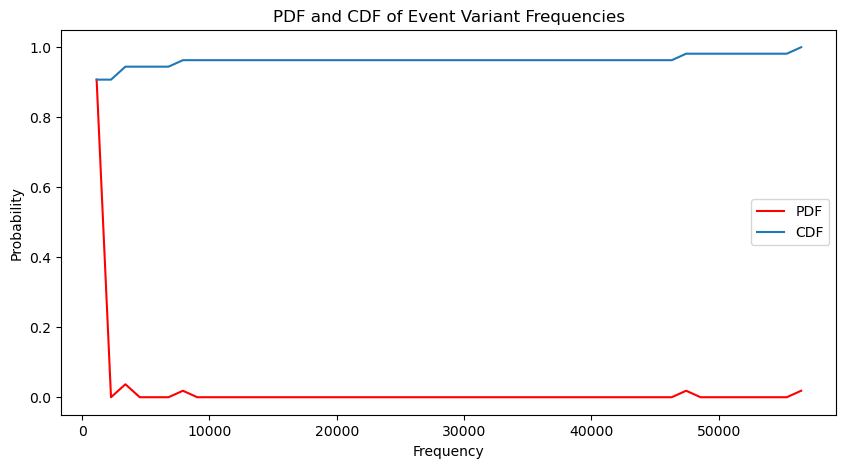

In [161]:
# Get variants and their frequencies
variants = pm4py.get_variants(filtered_log)
values = [count for variant, count in variants.items()]

# Calculate PDF and CDF
count, bins_count = np.histogram(values, bins=50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

# Plot PDF and CDF
plt.figure(figsize=(10, 5))
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.title('PDF and CDF of Event Variant Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Probability')
plt.legend()
plt.show()

### Accumulated Variant Frequency Coverage

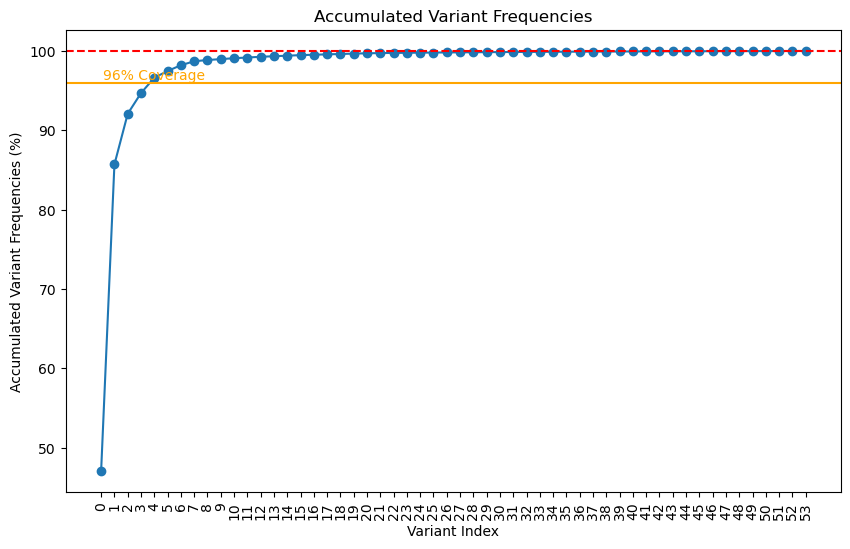

In [162]:
# Calculate accumulated frequencies and identify point for 96% coverage
total_frequency = sum(values)
ninetyperc = total_frequency * 0.96
accumulated_frequencies = np.cumsum(sorted(values, reverse=True))

# Plot accumulated frequencies
plt.figure(figsize=(10, 6))
plt.plot(range(len(accumulated_frequencies)), (accumulated_frequencies / total_frequency) * 100, marker='o')
plt.axhline(y=100, color='r', linestyle='--')
plt.axhline(y=96, color='orange', linestyle='-')
plt.xlabel('Variant Index')
plt.ylabel("Accumulated Variant Frequencies (%)")
plt.xticks(range(len(values)), rotation=90)
plt.title('Accumulated Variant Frequencies')
plt.text(np.where(accumulated_frequencies > ninetyperc)[0][0], 96, f'96% Coverage', ha='center', va='bottom', color='orange')
plt.show()


### Event Frequency Heatmap

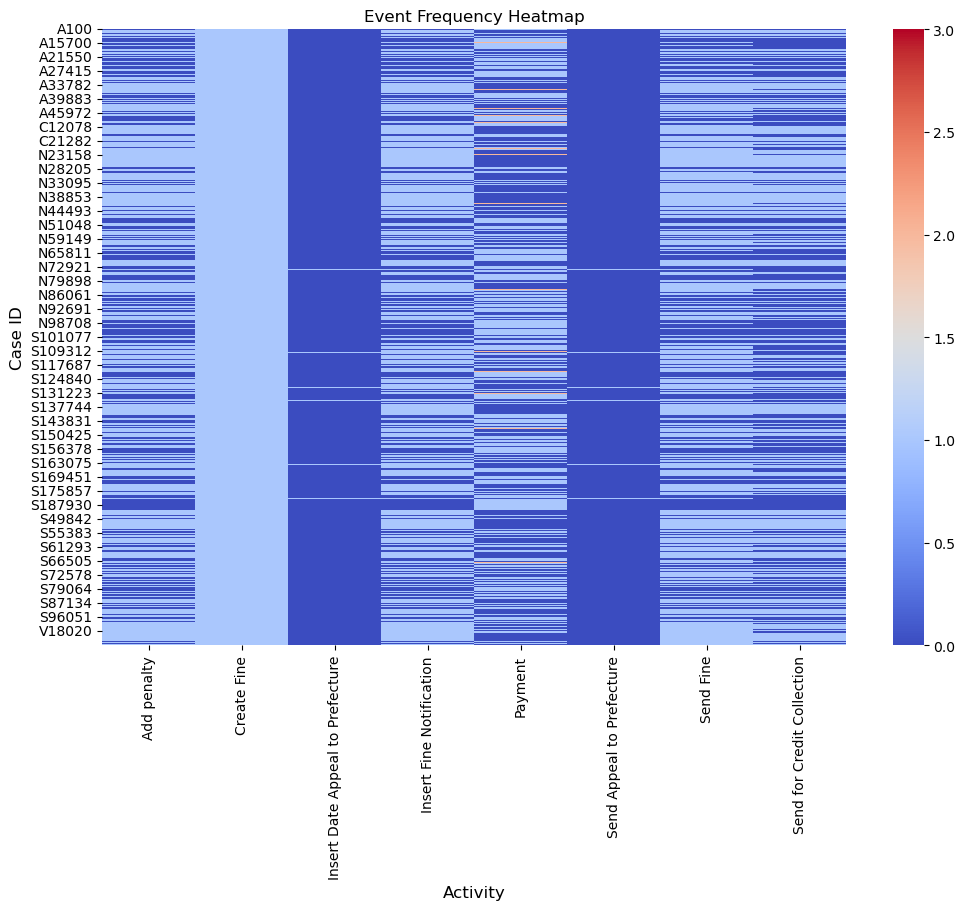

In [163]:
import seaborn as sns

# Filter top K variants (e.g., top 7)
filtered_log = pm4py.filter_variants_top_k(filtered_log, 7)

# Create cross-tabulation of cases and events
cases_events = pd.crosstab(filtered_log['case:concept:name'], filtered_log['concept:name'])

# Plot heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(cases_events, cmap="coolwarm", vmax=3)
heatmap.set_ylabel('Case ID', fontsize=12)
heatmap.set_xlabel('Activity', fontsize=12)
plt.title('Event Frequency Heatmap')
plt.show()


### ..............................................................................................
### Explicit analysis of factors leading to payment completion:

In [164]:
# Add this after your variant analysis

# Analyze factors leading to payment completion
payment_cases = filtered_log[filtered_log['concept:name'] == 'Payment']['case:concept:name'].unique()
non_payment_cases = filtered_log[~filtered_log['case:concept:name'].isin(payment_cases)]['case:concept:name'].unique()

# Compare characteristics of payment vs non-payment cases
payment_data = filtered_log[filtered_log['case:concept:name'].isin(payment_cases)]
non_payment_data = filtered_log[filtered_log['case:concept:name'].isin(non_payment_cases)]

# Analyze average fine amount for payment vs non-payment cases
avg_amount_payment = payment_data[payment_data['concept:name'] == 'Create Fine']['amount'].mean()
avg_amount_non_payment = non_payment_data[non_payment_data['concept:name'] == 'Create Fine']['amount'].mean()

print(f"Average fine amount for payment cases: {avg_amount_payment}")
print(f"Average fine amount for non-payment cases: {avg_amount_non_payment}")

# Analyze time to first action after Create Fine
payment_data['time_to_first_action'] = payment_data.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds() / 86400  # Convert to days
non_payment_data['time_to_first_action'] = non_payment_data.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds() / 86400

avg_time_to_action_payment = payment_data[payment_data['time_to_first_action'].notna()]['time_to_first_action'].mean()
avg_time_to_action_non_payment = non_payment_data[non_payment_data['time_to_first_action'].notna()]['time_to_first_action'].mean()

print(f"Average time to first action for payment cases: {avg_time_to_action_payment} days")
print(f"Average time to first action for non-payment cases: {avg_time_to_action_non_payment} days")

Average fine amount for payment cases: 38.815343163184345
Average fine amount for non-payment cases: 49.14206963283239
Average time to first action for payment cases: 60.09722027657148 days
Average time to first action for non-payment cases: 172.36171127359884 days


C:\Users\ARASH\AppData\Local\Temp\ipykernel_26156\2824417006.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ARASH\AppData\Local\Temp\ipykernel_26156\2824417006.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### ...........................................................................
### Analysis of the impact of appeals on the process:



In [165]:
# Add this after your variant analysis

# Analyze impact of appeals
appeal_cases = filtered_log[filtered_log['concept:name'].isin(['Send Appeal to Prefecture', 'Appeal to Judge'])]['case:concept:name'].unique()
non_appeal_cases = filtered_log[~filtered_log['case:concept:name'].isin(appeal_cases)]['case:concept:name'].unique()

appeal_data = filtered_log[filtered_log['case:concept:name'].isin(appeal_cases)]
non_appeal_data = filtered_log[filtered_log['case:concept:name'].isin(non_appeal_cases)]

# Compare durations
appeal_duration = appeal_data.groupby('case:concept:name')['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() / 86400).mean()
non_appeal_duration = non_appeal_data.groupby('case:concept:name')['time:timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() / 86400).mean()

print(f"Average duration for cases with appeals: {appeal_duration:.2f} days")
print(f"Average duration for cases without appeals: {non_appeal_duration:.2f} days")

# Analyze payment rates
appeal_payment_rate = len(appeal_data[appeal_data['concept:name'] == 'Payment']['case:concept:name'].unique()) / len(appeal_cases)
non_appeal_payment_rate = len(non_appeal_data[non_appeal_data['concept:name'] == 'Payment']['case:concept:name'].unique()) / len(non_appeal_cases)

print(f"Payment rate for cases with appeals: {appeal_payment_rate:.2%}")
print(f"Payment rate for cases without appeals: {non_appeal_payment_rate:.2%}")

Average duration for cases with appeals: 844.41 days
Average duration for cases without appeals: 384.37 days
Payment rate for cases with appeals: 0.00%
Payment rate for cases without appeals: 51.72%


### Visualizing Event Frequency Over Time: provide insights into workload distribution, process efficiency, or operational bottlenecks over different time periods.

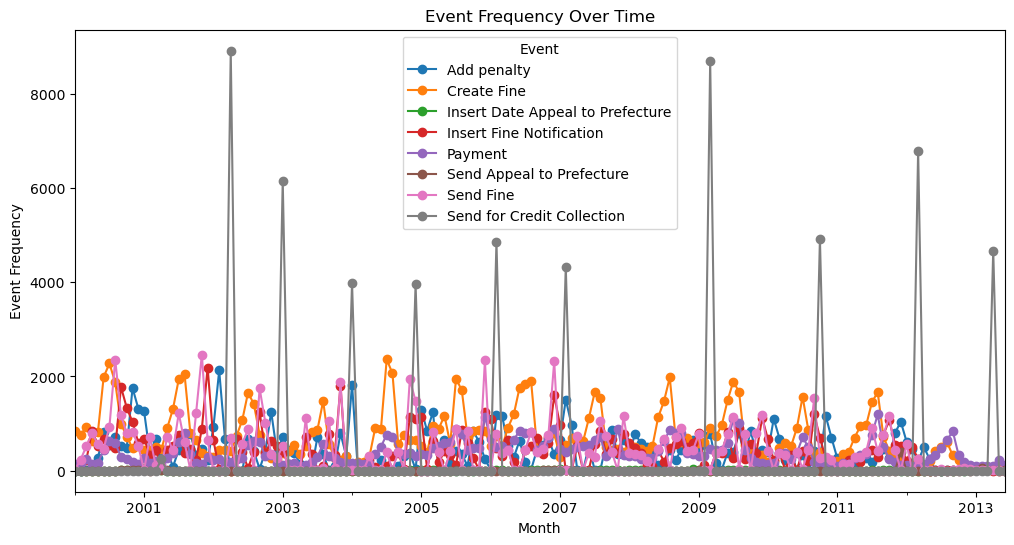

In [167]:
# Example: Plotting event frequency over time
event_counts_per_month = filtered_log.groupby(filtered_log['time:timestamp'].dt.to_period('M'))['concept:name'].value_counts().unstack().fillna(0)
event_counts_per_month.plot(kind='line', figsize=(12, 6), marker='o')
plt.xlabel('Month')
plt.ylabel('Event Frequency')
plt.title('Event Frequency Over Time')
plt.legend(title='Event')
plt.show()

In [168]:
# for KPI

# Calculate average cycle time
avg_cycle_time = filtered_log.groupby('case:concept:name')['time:timestamp'].apply(lambda x: x.max() - x.min()).mean()

# Calculate number of cases
num_cases = len(filtered_log['case:concept:name'].unique())

# Calculate total time period as the difference between the earliest and latest timestamp
total_time_period = filtered_log['time:timestamp'].max() - filtered_log['time:timestamp'].min()

# Calculate throughput (cases per unit time)
throughput = num_cases / total_time_period.total_seconds()  # Convert total_time_period to seconds for throughput calculation

# Print results
print(f"Average Cycle Time: {avg_cycle_time}")
print(f"Throughput: {throughput}")


Average Cycle Time: 387 days 18:53:37.255248016
Throughput: 0.0002774152788134891


### ...............................................................................
More detailed cost analysis:

Average management cost per case: $5102.04


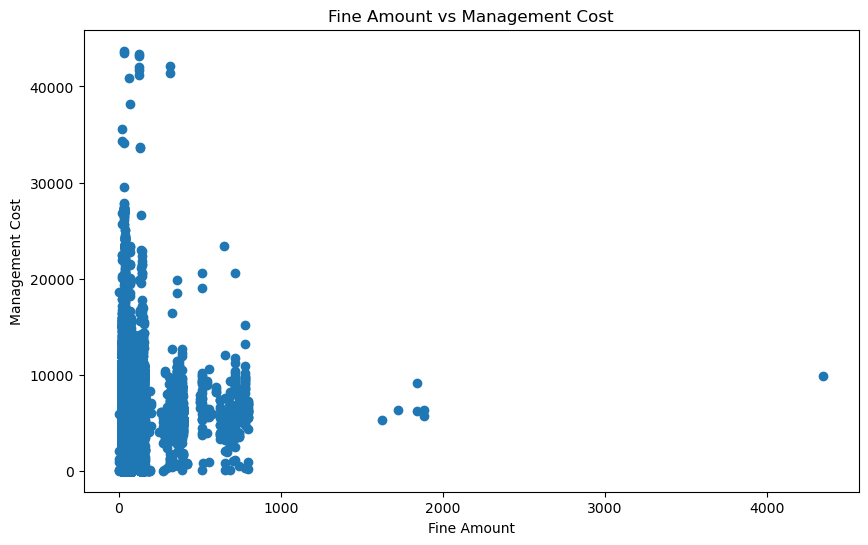

In [169]:
# Add this after your KPI calculations

# Calculate average management cost per case
filtered_log['case_duration'] = filtered_log.groupby('case:concept:name')['time:timestamp'].transform(lambda x: (x.max() - x.min()).total_seconds() / 86400)  # in days
avg_case_duration = filtered_log['case_duration'].mean()

# Assume a daily management cost
daily_management_cost = 10  # Example value

avg_management_cost = avg_case_duration * daily_management_cost

print(f"Average management cost per case: ${avg_management_cost:.2f}")

# Analyze relationship between fine amount and management cost
filtered_log['fine_amount'] = filtered_log[filtered_log['concept:name'] == 'Create Fine'].groupby('case:concept:name')['amount'].transform('first')

plt.figure(figsize=(10, 6))
plt.scatter(filtered_log['fine_amount'], filtered_log['case_duration'] * daily_management_cost)
plt.xlabel('Fine Amount')
plt.ylabel('Management Cost')
plt.title('Fine Amount vs Management Cost')
plt.show()

### Applying Alpha Miner Algorithm


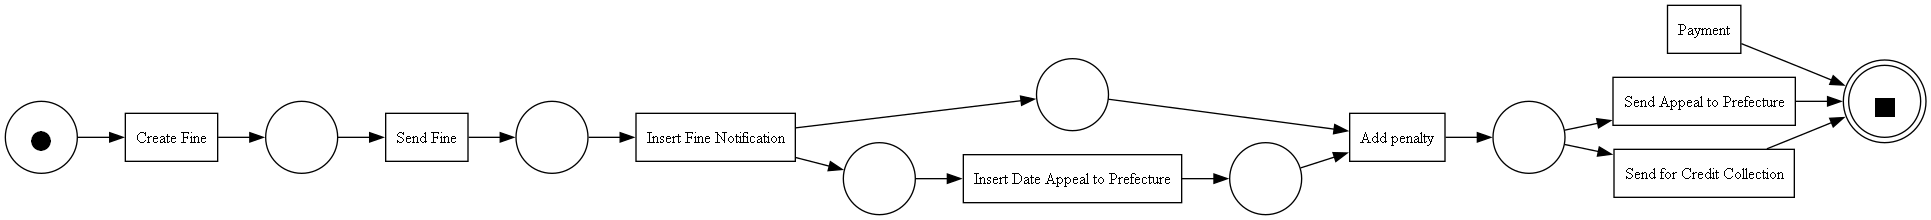

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

Alpha Miner Evaluation:
Fitness: {'perc_fit_traces': 0.7432925484073515, 'average_trace_fitness': 0.8409147981322437, 'log_fitness': 0.8382607157688797, 'percentage_of_fitting_traces': 0.7432925484073515}
Precision: 0.6334074415162139
Generalization: 0.988745343383376
Simplicity: 0.8888888888888888

Variants discovered in the log:
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection'), Occurrences: 56482
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment'), Occurrences: 7652
Variant: ('Create Fine', 'Payment'), Occurrences: 46372
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment'), Occurrences: 2326
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Send for Credit Collection'), Occurrences: 1012
Variant: ('Create Fine', 'Send Fine', 'Payment'), Occurrences: 3134
Variant: ('Create Fine', 'Send Fine', 

In [170]:
import pm4py
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# Apply Alpha Miner algorithm to discover Petri net
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(filtered_log)

# Visualize the Petri net
pm4py.view_petri_net(net, initial_marking, final_marking, format='png')

# Evaluate using token-based replay metrics
fitness = pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking)
precision = pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking)
generalization = generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking)
simplicity = simplicity_evaluator.apply(net)

# Print evaluation results
print("Alpha Miner Evaluation:")
print(f"Fitness: {fitness}")
print(f"Precision: {precision}")
print(f"Generalization: {generalization}")
print(f"Simplicity: {simplicity}")

# Get variants from the log
variants = pm4py.get_variants(filtered_log)

# Print variants and their occurrences
print("\nVariants discovered in the log:")
for variant, occurrence in variants.items():
    print(f"Variant: {variant}, Occurrences: {occurrence}")



### Applying Inductive Miner Algorithm


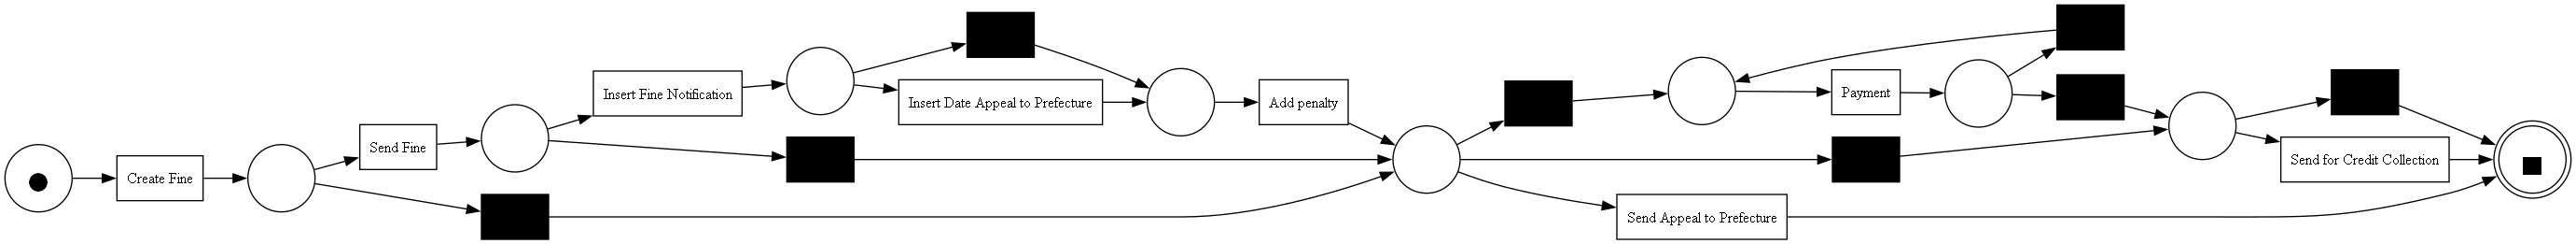

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

Inductive Miner Evaluation:
Fitness: {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Precision: 0.7119150775437115
Generalization: 0.9904020292568049
Simplicity: 0.6842105263157894

Variants discovered in the log:
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection'), Occurrences: 56482
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment'), Occurrences: 7652
Variant: ('Create Fine', 'Payment'), Occurrences: 46372
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment'), Occurrences: 2326
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Send for Credit Collection'), Occurrences: 1012
Variant: ('Create Fine', 'Send Fine', 'Payment'), Occurrences: 3134
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to 

In [171]:
# Apply Inductive Miner algorithm to discover Petri net
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(filtered_log)

# Visualize the Petri net
pm4py.view_petri_net(net, initial_marking, final_marking, format='png')

# Evaluate using token-based replay metrics
fitness = pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking)
precision = pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking)
generalization = generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking)
simplicity = simplicity_evaluator.apply(net)

# Print evaluation results
print("Inductive Miner Evaluation:")
print(f"Fitness: {fitness}")
print(f"Precision: {precision}")
print(f"Generalization: {generalization}")
print(f"Simplicity: {simplicity}")

# Get variants from the log
variants = pm4py.get_variants(filtered_log)

# Print variants and their occurrences
print("\nVariants discovered in the log:")
for variant, occurrence in variants.items():
    print(f"Variant: {variant}, Occurrences: {occurrence}")


### Applying Heuristic Miner Algorithm


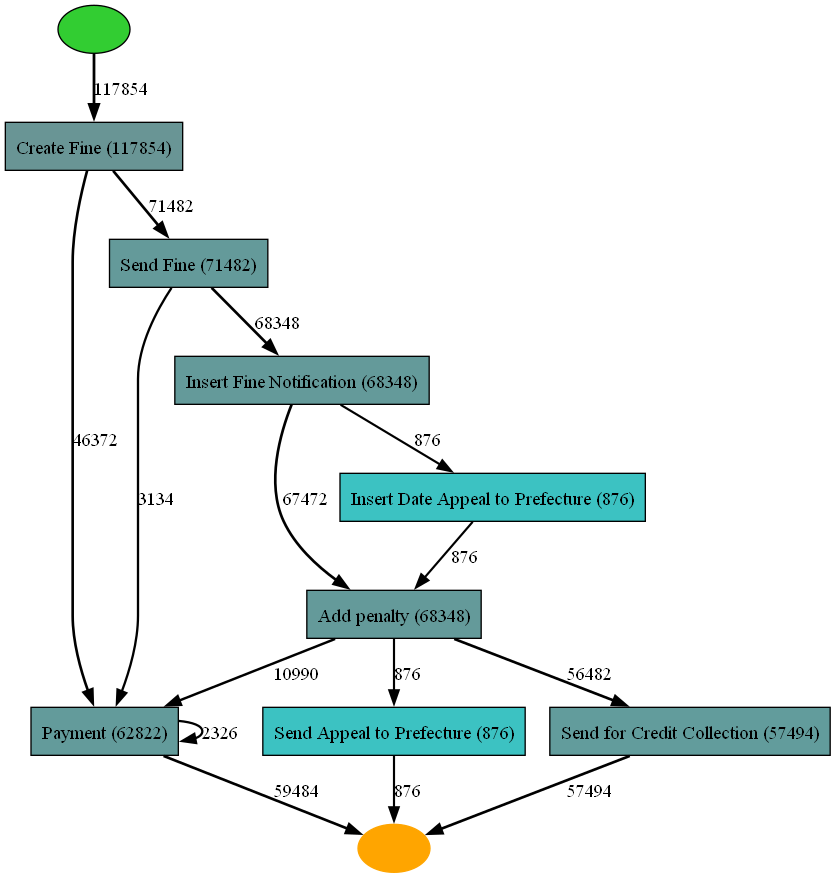

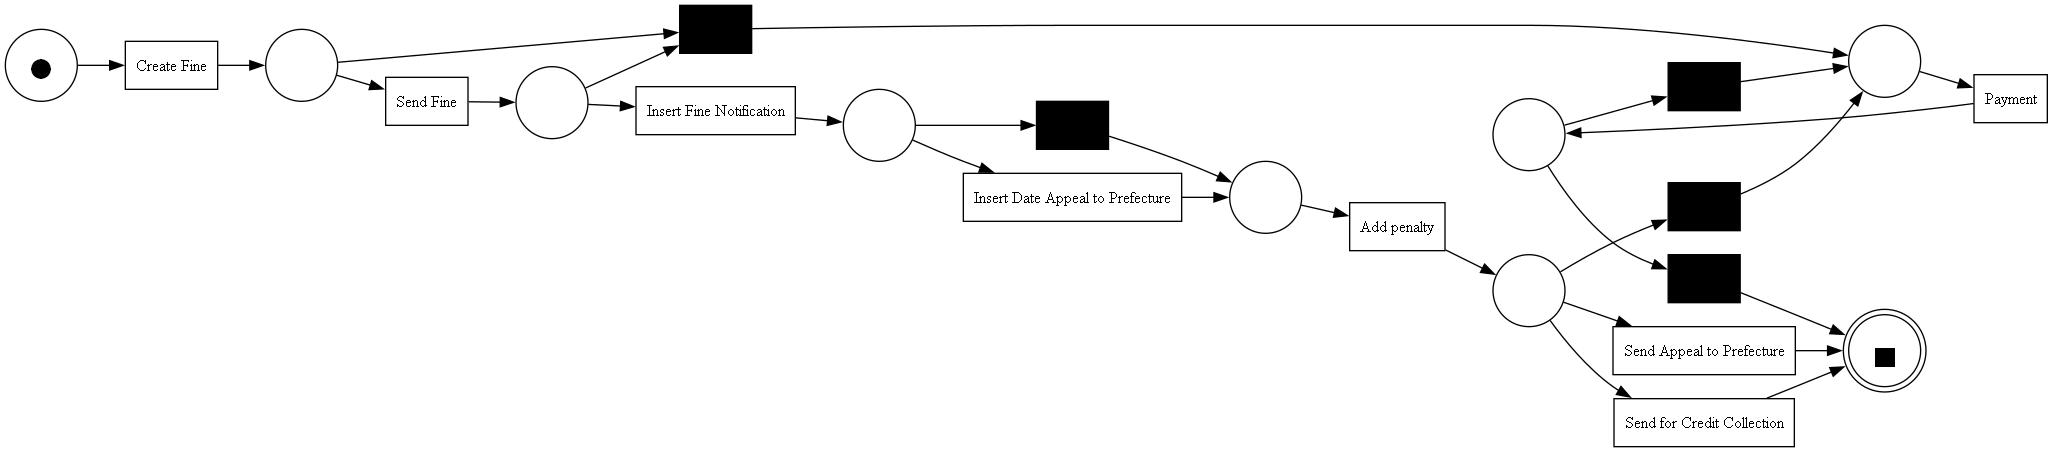

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/7 [00:00<?, ?it/s]

Heuristic Miner Evaluation:
Fitness: {'perc_fit_traces': 57.13509936022536, 'average_trace_fitness': 0.8953599840104034, 'log_fitness': 0.9284676576619949, 'percentage_of_fitting_traces': 57.13509936022536}
Precision: 0.9296067684235145
Generalization: 0.9132107120761577
Simplicity: 0.6875

Variants discovered in the log:
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Send for Credit Collection'), Occurrences: 56482
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment'), Occurrences: 7652
Variant: ('Create Fine', 'Payment'), Occurrences: 46372
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment'), Occurrences: 2326
Variant: ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Send for Credit Collection'), Occurrences: 1012
Variant: ('Create Fine', 'Send Fine', 'Payment'), Occurrences: 3134
Variant: ('Create Fine', 'Send Fine', 'Insert F

In [172]:
# Apply Heuristic Miner algorithm to discover Heuristics net and Petri net
heu_net = pm4py.discover_heuristics_net(filtered_log, dependency_threshold=0.99, and_threshold=0.99, loop_two_threshold=0.99)
pm4py.view_heuristics_net(heu_net)

net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(filtered_log, dependency_threshold=0.99, and_threshold=0.99, loop_two_threshold=0.99)
pm4py.view_petri_net(net, initial_marking, final_marking, format='png')

# Evaluate using token-based replay metrics
fitness = pm4py.fitness_token_based_replay(filtered_log, net, initial_marking, final_marking)
precision = pm4py.precision_token_based_replay(filtered_log, net, initial_marking, final_marking)
generalization = generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking)
simplicity = simplicity_evaluator.apply(net)

# Print evaluation results
print("Heuristic Miner Evaluation:")
print(f"Fitness: {fitness}")
print(f"Precision: {precision}")
print(f"Generalization: {generalization}")
print(f"Simplicity: {simplicity}")

# Get variants from the log
variants = pm4py.get_variants(filtered_log)

# Print variants and their occurrences
print("\nVariants discovered in the log:")
for variant, occurrence in variants.items():
    print(f"Variant: {variant}, Occurrences: {occurrence}")

### Building the Footprints

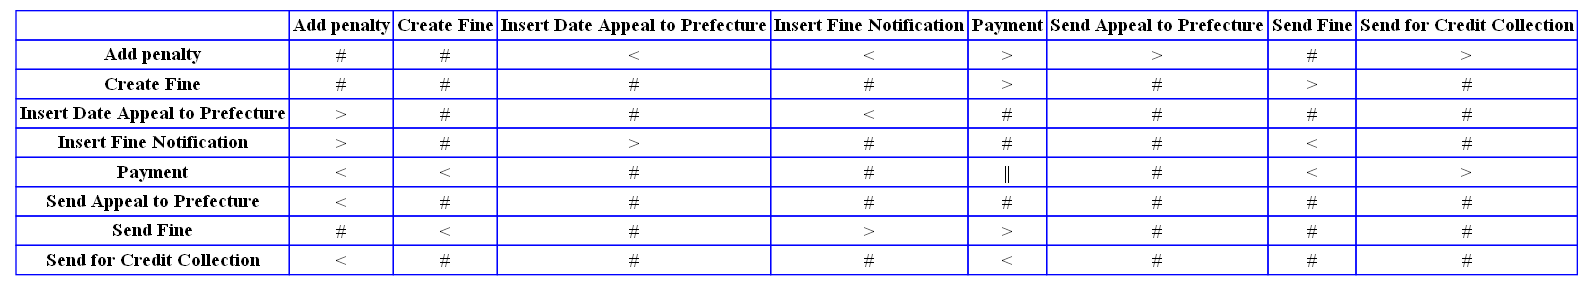

In [173]:
footprints = pm4py.discover_footprints(filtered_log)
pm4py.view_footprints(footprints, format='png')

### Performance Metrics of our Process Discovery Algorithms:

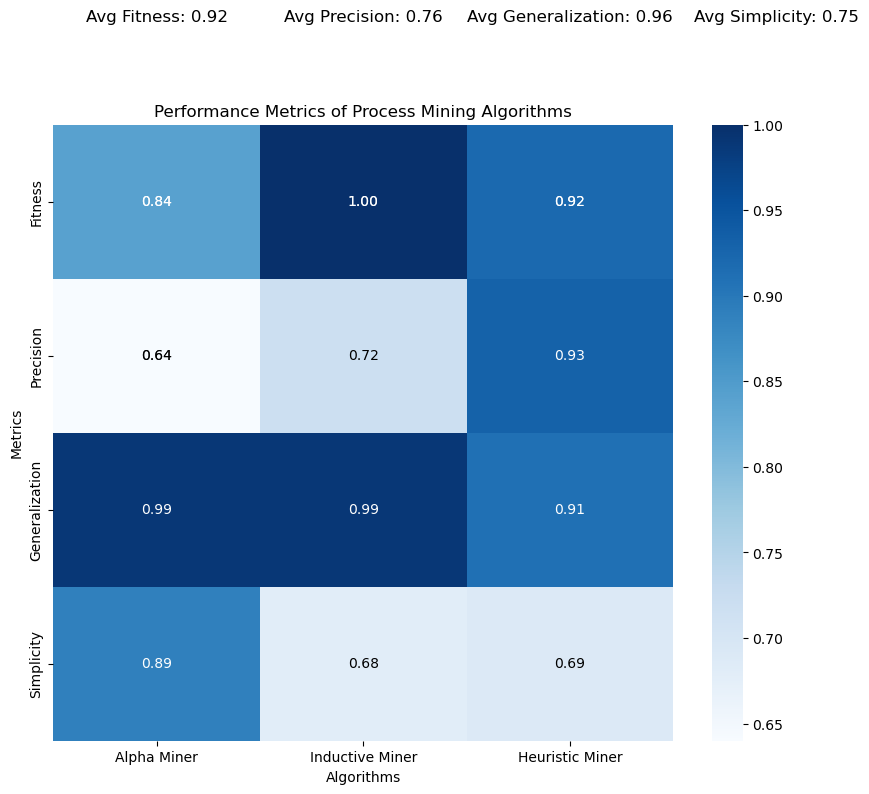

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample performance scores
data = np.array([
    [0.84, 1.0, 0.92],
    [0.64, 0.72, 0.93],
    generalization_scores,
    simplicity_scores
])

# Calculate average scores across algorithms for each metric
avg_fitness = np.mean(data[0, :])
avg_precision = np.mean(data[1, :])
avg_generalization = np.mean(data[2, :])
avg_simplicity = np.mean(data[3, :])

# Create a heatmap with annotations that change color based on the background
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", cbar=True,
                      xticklabels=['Alpha Miner', 'Inductive Miner', 'Heuristic Miner'],
                      yticklabels=['Fitness', 'Precision', 'Generalization', 'Simplicity'])

# Loop over the data to add text annotations
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        text_color = "white" if data[i, j] > 0.8 else "black"
        heatmap.text(j + 0.5, i + 0.5, f"{data[i, j]:.2f}",
                     ha="center", va="center", color=text_color)

# Add average scores annotations
plt.text(0.5, -0.7, f"Avg Fitness: {avg_fitness:.2f}", ha='center', va='center', fontsize=12, color='black')
plt.text(1.5, -0.7, f"Avg Precision: {avg_precision:.2f}", ha='center', va='center', fontsize=12, color='black')
plt.text(2.5, -0.7, f"Avg Generalization: {avg_generalization:.2f}", ha='center', va='center', fontsize=12, color='black')
plt.text(3.5, -0.7, f"Avg Simplicity: {avg_simplicity:.2f}", ha='center', va='center', fontsize=12, color='black')

# Set the title and labels
plt.title('Performance Metrics of Process Mining Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Metrics')

# Show the plot
plt.show()
